In [23]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from matplotlib.ticker import FuncFormatter

In [2]:
file_path = 'Data assignment 1/Feature data.csv'
data = pd.read_csv(file_path)
data2=pd.read_csv("Data process/Forcasted Weather data new.csv")

In [3]:
#Dropping the features that are not required for the analysis
data2=data2.drop('Accumulated percipitation', axis=1)
data2=data2.drop('Mean humidity', axis=1)
data2=data2.drop('Wind Speed Y Direction', axis=1)
data2=data2.drop('Wind Speed X Direction', axis=1)
data2=data2.drop('Mean temperature', axis=1)
data2=data2.drop('Minimum temperature', axis=1)
data2=data2.drop('Solar Shortwave Flux', axis=1)
data2=data2.drop('Unnamed: 0',axis=1)
data2.head()

,ts,Maximum temperature,Mean wind direction,Mean wind speed
0,2022-01-01 00:00:00,279.84314,235.57857,5.813893
1,2022-01-01 01:00:00,279.84314,235.57857,5.813893
2,2022-01-01 02:00:00,279.84314,235.57857,5.813893
3,2022-01-01 03:00:00,279.84314,235.57857,5.813893
4,2022-01-01 04:00:00,279.84314,235.57857,5.813893


## Step 2
### Feature scaling

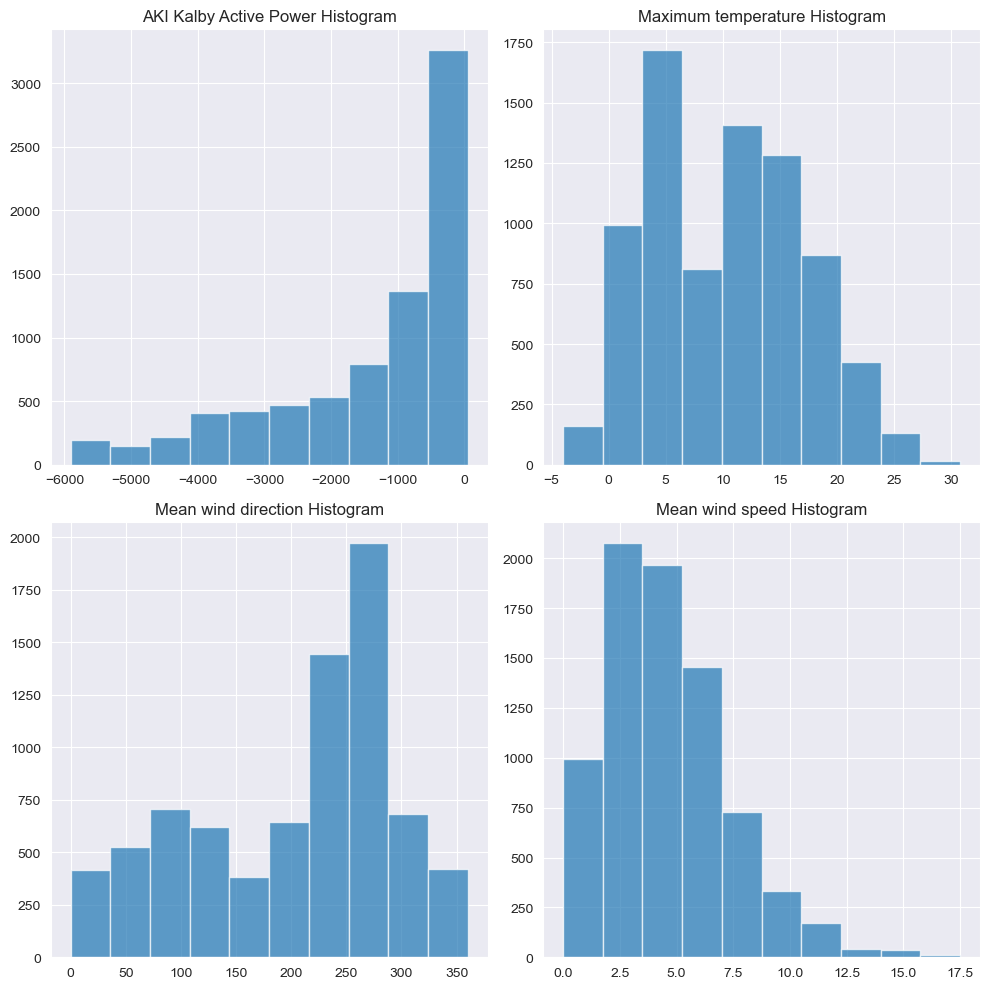

In [4]:
# Set 'datetime' as the index to exclude it from the figure
data.set_index('datetime', inplace=True)

# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each feature and plot its histogram
for i, col in enumerate(data.columns):
    axes[i].hist(data[col], alpha=0.7)
    axes[i].set_title(f'{col} Histogram')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

# Reset index back to default
data.reset_index(inplace=True)

In this step the different features are scaled, in order to make sure the models can interpret the features on a similar scale. The wind speed and the maximum temperature undergo the standardscaler, while wind direction is converted to sinus and cosinus components. The power production is normalized using the nominal capacity of 6 MW (https://stateofgreen.com/en/solutions/kalby-wind-turbines/). This number matches with the maximum produced power in 2022, which was about 5900 KW. 
 

In [5]:
# Import required scalers
scaler_standard = StandardScaler()

### 1. Standard Scaling for wind speed and temperature
data['Mean wind speed'] = scaler_standard.fit_transform(data[['Mean wind speed']])
data['Maximum temperature'] = scaler_standard.fit_transform(data[['Maximum temperature']])

### 2. Wind Direction (convert to sin and cos components)
data['Wind direction sin'] = np.sin(np.deg2rad(data['Mean wind direction']))
data['Wind direction cos'] = np.cos(np.deg2rad(data['Mean wind direction']))

### 3. Normalize Power Production 
nominal_capacity = 6000 # production capacity is 30 MW, unit of power production is kW so nominal capacity is 6000 (kW)
data['AKI Kalby Active Power'] = data['AKI Kalby Active Power'] / nominal_capacity

# Dropping the original wind direction after scaling
data = data.drop('Mean wind direction', axis=1)

In [6]:
### 1. Standard Scaling for wind speed and temperature for the Forecasted Weather Data
data2['Mean wind speed'] = scaler_standard.fit_transform(data2[['Mean wind speed']])
data2['Maximum temperature'] = scaler_standard.fit_transform(data2[['Maximum temperature']])

### 2. Wind Direction (convert to sin and cos components) for the Forecasted Weather Data
data2['Wind direction sin'] = np.sin(np.deg2rad(data2['Mean wind direction']))
data2['Wind direction cos'] = np.cos(np.deg2rad(data2['Mean wind direction']))


# Dropping the original wind direction after transformation for the Forecasted Weather Data
data2 = data2.drop('Mean wind direction', axis=1)

In [7]:
# Make sure datetime is set as the index
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

In [8]:
# datetime is set as the index for the Forecasted Weather Data
data2['ts'] = pd.to_datetime(data2['ts'])
data2.set_index('ts', inplace=True)

In [9]:
# Set target and features, and remove non-numeric columns
target_column = 'AKI Kalby Active Power'
features = data.select_dtypes(include=[np.number]).drop(columns=[target_column])

In [10]:
# Load the dataframe to check if scaling worked
data.head()

,AKI Kalby Active Power,Maximum temperature,Mean wind speed,Wind direction sin,Wind direction cos
datetime,,,,,
2022-01-01 00:00:00,-0.315590,-0.457945,0.868655,-0.998630,-5.233596e-02
2022-01-01 01:00:00,-0.278639,-0.457945,0.382418,-0.956305,-2.923717e-01
2022-01-01 02:00:00,-0.478620,-0.503187,0.756447,-0.994522,-1.045285e-01
2022-01-01 03:00:00,-0.318628,-0.518268,0.494627,-1.000000,-1.836970e-16
2022-01-01 04:00:00,-0.146959,-0.473025,0.307612,-0.951057,3.090170e-01


### Constructing testing and training 
Using train_test_split the data is split into testing and training data. The choice was made to not use TimeSeriesSplit, because although the data is time based, the values are not dependent on the time of day in the sense that there is no strong temporal relationship that affects the observations. The power production is more weather dependent than anything else. 
 The data points can be treated independently of their time indices, allowing for a standard random sampling approach. By maintaining a randomized split, we also prevent potential biases that could arise from time-based sequences, ensuring that both the training and testing set represent the overall distribution of the dataset.

In [11]:
# Split the data
X = data.drop(columns=[target_column])
y = data[target_column]

# Select a 100 datapoints as a start with a low number of samples
X_sample = features[:100]
y_sample = data[target_column][:100]

# Sequential split (shuffle=False)
# Give the random_state a set seed of 42, to ensure that the split will be the same everytime in order to reproduce results
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, shuffle=False, random_state=42)

#Ensure that they are the same data points, for easy comparison
X_forecast_sample = data2[data2.index.isin(pd.to_datetime(y_sample_test.index))]
X_forecast_sample = X_forecast_sample.reindex(y_sample_test.index)

# Adding a column of ones to X_sample for the bias term and converting to NumPy array
X_sample_train_with_bias = np.c_[np.ones(X_sample_train.shape[0]), X_sample_train].astype(float)
X_sample_test_with_bias = np.c_[np.ones(X_sample_test.shape[0]), X_sample_test].astype(float)
X_forecast_sample_with_bias=np.c_[np.ones(X_forecast_sample.shape[0]), X_forecast_sample].astype(float)

# Ensure y_sample_train is also a NumPy array
y_sample_train = np.array(y_sample_train).astype(float)

In [12]:
full_forecast_data_with_bias=np.c_[np.ones(data2.shape[0]), data2].astype(float)

### Step 3 Linear regression

In [13]:
# Gradient Descent function
def gradient_descent(X, y, learning_rate=0.01, epochs=100000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(epochs):
        y_pred = X @ theta
        gradients = (1/m) * X.T @ (y_pred - y)
        theta -= learning_rate * gradients
    return theta

theta_gd = gradient_descent(X_sample_train_with_bias, y_sample_train)

In [14]:
# Predictions for Forecasted Data and test data using Gradient Descent
y_pred_gd = X_sample_test_with_bias @ theta_gd

In [15]:
# Closed-form solution 
theta_closed_form = np.linalg.inv(X_sample_train_with_bias.T @ X_sample_train_with_bias) @ X_sample_train_with_bias.T @ y_sample_train

# Predictions using closed-form solution
y_pred_closed_form = X_sample_test_with_bias @ theta_closed_form

In [16]:
# mse calculation
rmse_gd = np.sqrt(mean_squared_error(y_sample_test, y_pred_gd))
rmse_closed_form =np.sqrt(mean_squared_error(y_sample_test, y_pred_closed_form))

print(f"Gradient Descent θ: {[f'{x:.5f}' for x in theta_gd]}")
print(f"Closed-Form θ: {[f'{x:.5f}' for x in theta_closed_form]}")
print(f"Gradient Descent MSE: {rmse_gd:.5f}")
print(f"Closed-Form MSE: {rmse_closed_form:.5f}")

Gradient Descent θ: ['-0.18946', '0.12962', '-0.20596', '0.05759', '0.05581']
Closed-Form θ: ['-0.18946', '0.12962', '-0.20596', '0.05759', '0.05581']
Gradient Descent MSE: 0.15724
Closed-Form MSE: 0.15724


In [17]:
# Step 3.2: Use the full dataset and closed form solution
X_large_sample, X_large_test_sample, y_large_sample, y_large_test_sample = train_test_split(features, data[target_column], test_size=0.2, random_state=42)
                              
# Adding a column of ones for the bias term in the large sample
X_large_sample_with_bias = np.c_[np.ones(X_large_sample.shape[0]), X_large_sample]
X_large_test_sample_with_bias = np.c_[np.ones(X_large_test_sample.shape[0]), X_large_test_sample]

# Upgrade the normal equation
theta_large_sample = np.linalg.inv(X_large_sample_with_bias.T @ X_large_sample_with_bias) @ X_large_sample_with_bias.T @ y_large_sample
theta_large_sample_rounded = np.round(theta_large_sample, 5)

print(f"Step 3.2: Closed-form solution training complete on the larger sample.")
print(f"Coefficients: {[f'{x:.5f}' for x in theta_large_sample_rounded]}")

Step 3.2: Closed-form solution training complete on the larger sample.
Coefficients: ['-0.21969', '0.00078', '-0.19546', '0.02953', '0.01828']


In [18]:
# Step 3.3: Verify your model using the testing dataset and appropriate evaluation metrics with the new merged dataset
y_large_pred_closed_form_test = X_large_test_sample_with_bias @ theta_large_sample

rmse = np.sqrt(mean_squared_error(y_large_test_sample, y_large_pred_closed_form_test))

print(f"Step 3.3: Model evaluation on the testing dataset:")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")

Step 3.3: Model evaluation on the testing dataset:
Root Mean Squared Error (RMSE): 0.15080


In [19]:
#Creating the final matrix containing the predicted values for Wind Power using the Forecasted Weather Data
LinReg = full_forecast_data_with_bias @ theta_large_sample

### Step 4 Non-linear Regression

In Step 1's formulation, if the price $\lambda$ is treated as a constant and the actual value p is known, the entire formula simplifies into a function dependent on the predicted value $\hat{p}_t$. This implies that the problem can be reframed as an optimization task concerning the prediction of $\hat{p}_t$. Given this perspective, extending the linear regression model from Step 3 by incorporating nonlinear features to predict $\hat{p}_t$ effectively transforms the problem into a nonlinear regression for Step 1's objective. Therefore, performing nonlinear regression on the prediction model of $\hat{p}_t$ inherently satisfies the requirements of the nonlinear extension outlined in Step 4.

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score

### Polynomial

In [21]:
# Define cross-validation function, which returns RMSE
def perform_cross_validation(X, y, degree, n_splits=10):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Initialize linear regression model
    linear_model = LinearRegression()
    
    # Use KFold for cross-validation, n_splits set to 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Compute RMSE via cross-validation (use negative MSE and then take the square root)
    neg_mse_scores = cross_val_score(linear_model, X_poly, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Convert negative MSE to RMSE
    rmse_scores = np.sqrt(-neg_mse_scores)
    
    # Return the mean RMSE
    return rmse_scores.mean()

In [22]:
# Polynomial degrees to evaluate: 2, 3, and 4
degrees = [2, 3, 4]
best_degree = None
best_rmse = float('inf')

# Perform cross-validation for each polynomial degree
for degree in degrees:
    print(f"Evaluating degree {degree} polynomial: ")
    rmse = perform_cross_validation(features, data[target_column], degree)
    print(f"Mean RMSE for degree {degree}: {rmse:.5f}")
    
    # Update the best model based on RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_degree = degree

Evaluating degree 2 polynomial: 
Mean RMSE for degree 2: 0.14815
Evaluating degree 3 polynomial: 
Mean RMSE for degree 3: 0.13812
Evaluating degree 4 polynomial: 
Mean RMSE for degree 4: 0.13625


In [23]:
print(f"Best degree is {best_degree} with RMSE: {best_rmse:.5f}")

Best degree is 4 with RMSE: 0.13625


In [24]:
# Generate the best polynomial features
poly_best = PolynomialFeatures(degree=best_degree, include_bias=False)
X_poly_best = poly_best.fit_transform(features)

# Split the data into training and testing sets
X_train_poly_best, X_test_poly_best, y_train_poly_best, y_test_poly_best = train_test_split(
    X_poly_best, data[target_column], test_size=0.2, random_state=42)

#Transform the forecast weather data to be used in the polynomial nonlinear regression later
full_X_forecast_poly = poly_best.fit_transform(data2)

# Train the final polynomial model
nonlinear_model_best = LinearRegression()
nonlinear_model_best.fit(X_train_poly_best, y_train_poly_best)

# Make predictions on the test set
y_pred_poly_best_test = nonlinear_model_best.predict(X_test_poly_best)

test_rmse_best = np.sqrt(mean_squared_error(y_test_poly_best, y_pred_poly_best_test))

# Evaluation
print(f"RMSE for the best degree {best_degree}: {test_rmse_best:.5f}")

RMSE for the best degree 4: 0.13762


In [25]:
# Creating the final matrix containing the predicted values for Wind Power using the Forecasted Weather Data for entire 2022
# Using the polynomial model
X_forecast_poly_best_final = poly_best.fit_transform(data2)
y_pred_poly_best_forecast = nonlinear_model_best.predict(X_forecast_poly_best_final)
y_pred_poly_best_forecast

array([-0.51832819, -0.51832819, -0.51832819, ..., -0.37611914,
       -0.38702059, -0.35104513])

In [26]:
# Extract coefficients
coefficients = nonlinear_model_best.coef_
intercept = nonlinear_model_best.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [-7.44336575e-03 -7.06747808e+07 -7.43879572e+08  2.19864697e+07
  2.27377851e+09  1.48621721e+08  2.50346930e+07  2.57697579e+07
 -3.36833327e+09 -1.22665691e+08 -5.16267518e+07  2.25167914e+09
  1.32382005e+08 -3.18394078e+09  7.35521617e-03  8.35628672e-03
  1.26009992e-02  2.30617994e-02 -8.32825051e-04 -1.47737698e-02
  7.35092275e-03 -2.21430506e-02  9.82916464e-03  1.47009546e-02
  1.81699227e-02 -1.95296941e-02  1.72094127e-02  7.06747805e+07
 -2.21053431e-03  7.06747805e+07  7.43879572e+08 -2.19864697e+07
  7.43879572e+08 -2.19864696e+07 -6.56580925e-03  1.94299221e-03
 -8.43501091e-03 -1.16164684e-02 -4.69803810e-03  8.98718834e-03
  1.91396475e-02 -2.27377851e+09  1.51290894e-02 -2.27377851e+09
  1.94978714e-03  6.82252645e-03  7.00992346e-03 -1.48621721e+08
 -2.73930281e-03 -1.48621721e+08 -2.50346930e+07 -2.57697580e+07
 -2.50346930e+07 -2.57697579e+07 -2.24614143e-03 -6.77204132e-03
 -8.76498222e-03  3.36833327e+09 -2.19722986e-02  3.36833327e+09
  1.2266569

### Locally weighted least squares

For step 4.2, the method of locally weighted least squares will be used, as tought in the lecture. Different kernels will be compared and the best one will be chosen based on evaluating the performance on the test data.

In [27]:
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return res

def tricube(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return res

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return res

In [28]:
# Locally Weighted Least Squares implementation
def lwls_predict(X_train, y_train, X_test, kernel_func, tau=0.1):
    y_pred = np.zeros(len(X_test))

    for i, x in enumerate(X_test):
        distances = np.linalg.norm(X_train - x, axis=1)  # Compute distances
        weights = kernel_func(distances / tau)  # Apply kernel function
        W = np.diag(weights)  # Create diagonal weight matrix

        # Weighted Least Squares computation
        XTWX = X_train.T @ W @ X_train  # X^T W X
        XTWy = X_train.T @ W @ y_train  # X^T W y

        # Use np.linalg.pinv for numerical stability
        theta = np.linalg.pinv(XTWX) @ XTWy

        # Ensure x is 2D before matrix multiplication
        y_pred[i] = np.dot(x, theta)  # Prediction for the current test sample

    return y_pred

In [29]:
# Function to evaluate different kernels and select the best one
def evaluate_kernels(X_train, y_train, X_test, y_test, kernels, tau=0.1):
    mse_results = {}

    for kernel_name, kernel_func in kernels.items():

        y_pred = lwls_predict(X_train, y_train, X_test, kernel_func, tau=tau)
        mse = mean_squared_error(y_test, y_pred)
        mse_results[kernel_name] = mse

    return mse_results

# Example kernels (ensure these are defined somewhere in the code)
kernels = {
    'Gaussian': gaussian,
    'Epanechnikov': epanechnikov,
    'Tricube': tricube,
    'Uniform': uniform,
    'Triangle': triangle
}

In [30]:
# Evaluate kernels on smaller data for faster results
mse_results_small = evaluate_kernels(X_sample_train_with_bias, y_sample_train, X_sample_test_with_bias, y_sample_test, kernels)
min_kernel, min_mse = min(mse_results_small.items(), key=lambda x: x[1])

# Print the full results and the minimum one
print(mse_results_small)
print(f"The kernel with the smallest MSE is '{min_kernel}' with a value of {min_mse}")


{'Gaussian': 0.4278653771802266, 'Epanechnikov': 0.395964085249608, 'Tricube': 0.395964085249608, 'Uniform': 0.024723402431518902, 'Triangle': 0.395964085249608}
The kernel with the smallest MSE is 'Uniform' with a value of 0.024723402431518902


In [31]:
# Evaluation on the kernel selected
def evaluate_uniform(X_train, y_train, X_test, y_test, uniform, tau=0.1):
    for kernel_name, kernel_func in uniform.items():
        y_pred = lwls_predict(X_train, y_train, X_test, kernel_func, tau=tau)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse_wls_uniform = np.sqrt(mse)
        
        print(f"{kernel_name} Kernel Results:")
        print(f"Root Mean Squared Error (RMSE): {rmse_wls_uniform}")

    return

uniform_kernel = {
    'Uniform': uniform
}

evaluate_uniform(X_large_sample_with_bias, y_large_sample, X_large_test_sample_with_bias, y_large_test_sample, uniform_kernel)

Uniform Kernel Results:
Root Mean Squared Error (RMSE): 0.15080310672659306


In [32]:
# Creating the final matrix containing the predicted values for Wind Power using the Forecasted Weather Data
# Using the Uniform Kernel 
y_pred_forecast_nl2 = lwls_predict(X_sample_train_with_bias, y_sample_train, full_forecast_data_with_bias, kernels['Uniform'], tau=0.1)
y_pred_forecast_nl2

array([-0.57492536, -0.57492536, -0.57492536, ..., -0.41091465,
       -0.42931328, -0.37142976])

In [34]:
# Exporting the final predicted values 
Final_Power={'Linear Regression':LinReg,'Non-Linear Regression 1':y_pred_poly_best_forecast,'Non-Linear Regression 2':y_pred_forecast_nl2}
df = pd.DataFrame(Final_Power)
df['Linear Regression'] = df['Linear Regression']*6000 # Rescaling the normalized predicted values using the production capacity (30 kW)
df['Non-Linear Regression 1'] = df['Non-Linear Regression 1']*6000
df['Non-Linear Regression 2'] = df['Non-Linear Regression 2']*6000
df.to_csv('Final_power.csv', index=False)

### Step 5 Regularization
Ridge and Lasso regression are applied to test if the variance of the dataset can and has to be improved. Applying one of these techniques could make the model more stable and improve the prediction. 
Different alpha values are tested to see which one results in the best results. Both for Lasso and Ridge the goal is to minimize the mean squared error. To find the optimal alpha values GridSearchCV is used, which applies 5-fold cross-validation. 

### Regularization linear model

In [85]:
# Create a list with possible alpha values to iterate over
alpha_values = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}

# Ridge model with cross-validation
ridge_model_linear = Ridge()
# Apply GridSearchCV to search for the optimal alpha
ridge_cv_linear = GridSearchCV(ridge_model_linear, param_grid=alpha_values, cv=5, scoring='neg_mean_squared_error') # cv=5 for 5-fold cross-validation, scoring mean squared error because the goal is to get this as low as possible
ridge_cv_linear.fit(X_large_sample, y_large_sample)

# Lasso model with cross-validation
lasso_model_linear = Lasso()
# Apply GridSearchCV to search for the optimal alpha
lasso_cv_linear = GridSearchCV(lasso_model_linear, param_grid=alpha_values, cv=5, scoring='neg_mean_squared_error') # cv=5 for 5-fold cross-validation, scoring mean squared error because the goal is to get this as low as possible
lasso_cv_linear.fit(X_large_sample, y_large_sample)

# Get the best alpha values
best_alpha_ridge_linear = ridge_cv_linear.best_params_['alpha']
best_alpha_lasso_linear = lasso_cv_linear.best_params_['alpha']

print(f"Optimal alpha for Ridge for linear regression: {best_alpha_ridge_linear}")
print(f"Optimal alpha for Lasso for linear regression: {best_alpha_lasso_linear}")

Optimal alpha for Ridge for linear regression: 1
Optimal alpha for Lasso for linear regression: 0.0001


In [86]:
# Run the lasso model with the optimal alpha with the training data
lasso_model_linear = Lasso(alpha=best_alpha_lasso_linear)
lasso_model_linear.fit(X_large_sample, y_large_sample)

# Predict the power production with Lasso regularization
y_pred_lasso = lasso_model_linear.predict(X_large_test_sample)

# Show the new coefficients
lasso_model_linear.coef_

array([ 0.00068889, -0.19541345,  0.02937868,  0.01802122])

In [87]:
# Verify the model using the testing dataset and appropriate evaluation metrics
rmse_lasso_linear = np.sqrt(mean_squared_error(y_large_test_sample, y_pred_lasso))

print(f"Evaluation metrics Lasso for linear regression with a penalty of 0.0001:")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso_linear:.4f}")

Evaluation metrics Lasso for linear regression with a penalty of 0.0001:
Root Mean Squared Error (RMSE): 0.1508


In [88]:
# Run the ridge model with the optimal alpha
ridge_model_linear = Ridge(alpha=best_alpha_ridge_linear)
ridge_model_linear.fit(X_large_sample,y_large_sample)

# Predict the power production with Ridge regularization
y_pred_ridge = ridge_model_linear.predict(X_large_test_sample)

# Show the new coefficients
ridge_model_linear.coef_

array([ 0.00078409, -0.19542469,  0.02952416,  0.01828094])

In [89]:
# Verify the model using the testing dataset and appropriate evaluation metrics
rmse_ridge_linear = np.sqrt(mean_squared_error(y_large_test_sample, y_pred_lasso))

print(f"Model evaluation Ridge linear regression with a penalty of 1:")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge_linear:.4f}")

Model evaluation Ridge linear regression with a penalty of 1:
Root Mean Squared Error (RMSE): 0.1508


In [90]:
# Run the ridge model with alpha of 0.0001 instead of 1
ridge_model_linear_low = Ridge(alpha=0.0001)
ridge_model_linear_low.fit(X_large_sample,y_large_sample)
# Predict the power production with Ridge regularization
y_pred_ridge_linear_low = ridge_model_linear_low.predict(X_large_test_sample)

# Show the new coefficients
ridge_model_linear_low.coef_

array([ 0.00078017, -0.19545661,  0.02952686,  0.01827837])

In [91]:
# Verify the model using the testing dataset and appropriate evaluation metrics
rmse_ridge_linear_low = np.sqrt(mean_squared_error(y_large_test_sample, y_pred_ridge_linear_low))

print(f"Model evaluation Ridge linear regression with a strength of 0.0001:")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge_linear_low:.4f}")

Model evaluation Ridge linear regression with a strength of 0.0001:
Root Mean Squared Error (RMSE): 0.1508


The optimal penalty term for Lasso regression is 0.0001. This results in validation metric values with almost the same results as normal regression. Moreover, such a small penalty term indicates that it would be better to simply apply normal regression. This makes sense because for this model n>>p. There is a very large amount of data points and only 4 parameters. Consequently, there is already very low variance, before regularization is applied, minimizing the need for additional regularization. 

Ridge regression shows similar results, with one notable difference. For Ridge regression, it does not matter whether the penalty term is set to 1 or to 0.0001. The validation metrics remain exactly the same. This indicates that the data is inherently regularized; there is already a very low variance and the Ridge regression is not required to improve results. 


### Regularization Polynomial nonlinear model

In [92]:
# Create a list with possible alpha values to iterate over
alpha_values = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}

# Ridge model with cross-validation
ridge_model_poly = Ridge()
# Apply GridSearchCV to search for the optimal alpha
ridge_cv_poly = GridSearchCV(ridge_model_poly, param_grid=alpha_values, cv=5, scoring='neg_mean_squared_error') # cv=5 for 5-fold cross-validation, scoring mean squared error because the goal is to get this as low as possible
ridge_cv_poly.fit(X_train_poly_best,y_train_poly_best)

# Lasso model with cross-validation
lasso_model_poly = Lasso()
# Apply GridSearchCV to search for the optimal alpha
lasso_cv_poly = GridSearchCV(lasso_model_poly, param_grid=alpha_values, cv=5, scoring='neg_mean_squared_error') # cv=5 for 5-fold cross-validation, scoring mean squared error because the goal is to get this as low as possible
# lasso_cv.fit(X_large_test_sample,y_large_test_sample)
lasso_cv_poly.fit(X_train_poly_best,y_train_poly_best)

# Get the best alpha values
best_alpha_ridge_poly = ridge_cv_poly.best_params_['alpha']
best_alpha_lasso_poly = lasso_cv_poly.best_params_['alpha']

print(f"Optimal alpha for Ridge for polynomial regression: {best_alpha_ridge_poly}")
print(f"Optimal alpha for Lasso for polynomial regression: {best_alpha_lasso_poly}")

C:\Users\ilsed\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.867e+01, tolerance: 3.122e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\ilsed\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.886e+01, tolerance: 3.160e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\ilsed\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.889e+01, toleranc

Optimal alpha for Ridge for polynomial regression: 10
Optimal alpha for Lasso for polynomial regression: 0.0001


C:\Users\ilsed\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.879e+01, tolerance: 3.936e-02
  model = cd_fast.enet_coordinate_descent(


In [93]:
# Run the lasso model with the optimal alpha for the new Forecasted Dataset
lasso_model_poly = Lasso(alpha=best_alpha_lasso_poly)
lasso_model_poly.fit(X_train_poly_best,y_train_poly_best)

# Predict the power production with Lasso regularization
y_pred_lasso_poly = lasso_model_poly.predict(X_test_poly_best)
full_y_pred_lasso_poly_forecast = lasso_model_poly.predict(full_X_forecast_poly)

C:\Users\ilsed\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.879e+01, tolerance: 3.936e-02
  model = cd_fast.enet_coordinate_descent(


In [94]:
# Verify the model using the testing dataset and appropriate evaluation metrics
rmse_lasso_poly = np.sqrt(mean_squared_error(y_test_poly_best, y_pred_lasso_poly))

print(f"Model evaluation Lasso polynomial regression with a strength of 0.0001:")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso_poly:.4f}")

Model evaluation Lasso polynomial regression with a strength of 0.0001:
Root Mean Squared Error (RMSE): 0.1375


In [95]:
# Run the lasso model with the optimal alpha for the new Forecasted Dataset
ridge_model_poly = Ridge(alpha=best_alpha_ridge_poly)
ridge_model_poly.fit(X_train_poly_best,y_train_poly_best)

# Predict the power production with Lasso regularization
y_pred_ridge_poly = ridge_model_poly.predict(X_test_poly_best)
full_y_pred_ridge_poly_forecast = ridge_model_poly.predict(full_X_forecast_poly)

In [96]:
# Verify the model using the testing dataset and appropriate evaluation metrics
rmse_ridge_poly = np.sqrt(mean_squared_error(y_test_poly_best, y_pred_ridge_poly))

print(f"Model evaluation Ridge polynomial regression with a penalty of 0.0001:")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge_poly:.4f}")

Model evaluation Ridge polynomial regression with a penalty of 0.0001:
Root Mean Squared Error (RMSE): 0.1376


### Step 6 Revenue Calculation 
Based on the predicted wind production of the previously built models, optimal bidding strategies are derived. On an hourly basis the bidding strategy's optimization problem is executed and the respective revenue determined. 

In [25]:
# Helping Function that limits the observed timeframe
def ObservationPeriod(Start_Observation, End_Observation, data):
    Start_Observation = pd.to_datetime(Start_Observation)
    End_Observation = pd.to_datetime(End_Observation)
    condition = (data["HourDK"]>= Start_Observation) & (data["HourDK"]< End_Observation)
    data  = data[condition]
    return data


In [29]:
# OptimizationProblem function that formulates and solves the optimization Problem for each given hourly datapoint 
def OptimizationProblemEnergybid(data):
    model = gp.Model()
    model.setParam('OutputFlag', 0)
    solutions  = list()
    capacity = 6000.0
    
    for index, row in data.iterrows():
        
        #Skipr rows in the dataset that are NaN
        if pd.isnull(row[['p_t', 'DA_PriceEUR', 'BalancingPriceDownEUR', 'BalancingPriceUpEUR']]).any():
            continue
        
        #define the decision variable p_t_hat as well as auxilliary variables z_down, z_up, condition_down and condition_up
        p_t_hat = model.addVar(name="p_t_hat", lb=0, ub=capacity, vtype=GRB.INTEGER)
        z_down = model.addVar(name="z_down", vtype=GRB.CONTINUOUS, lb=0)
        z_up = model.addVar(name="z_up", vtype=GRB.CONTINUOUS, lb=0)
        condition_down = model.addVar(name="condition_down", vtype=GRB.BINARY)
        condition_up = model.addVar(name="condition_up", vtype=GRB.BINARY)
        
        #definition of constraint
        model.addConstr(z_up <= (p_t_hat - row['p_t']) * condition_up)
        model.addConstr(z_up >= (p_t_hat - row['p_t']) * condition_up)
        model.addConstr(z_down <= (row['p_t'] - p_t_hat) * condition_down)
        model.addConstr(z_down >= (row['p_t'] - p_t_hat) * condition_down)
        model.addConstr(condition_up + condition_down == 1)
        model.addConstr(-p_t_hat <= 0)
        model.addConstr(p_t_hat <= capacity)
        model.addConstr(-z_down <= 0)
        model.addConstr(-z_up <= 0)
        
        #definition of objective function
        model.setObjective((row['DA_PriceEUR']*p_t_hat)+(row['BalancingPriceDownEUR']*z_down-row['BalancingPriceUpEUR']*z_up), GRB.MAXIMIZE)
        
        #optimize given optimization problem
        model.optimize()
    
        if model.status == GRB.OPTIMAL:
            values = {"Day-Ahead-Price": row['DA_PriceEUR'],
                      "BalancingPriceUp":row['BalancingPriceUpEUR'],
                      "BalancingPriceDown":row['BalancingPriceDownEUR'],
                      "p_t":row['p_t'],
                      "Revenue":model.ObjVal
                      }
            values.update({v.varName: v.x for v in model.getVars()})
        
            
            solutions.append({row['HourDK']:values})
                
        elif model.status == GRB.INFEASIBLE:
            print("Model is infeasible.")
            model.computeIIS()
            model.write("infeasible.ilp")  # Write IIS to a file for review
            for c in model.getConstrs():
                if c.IISConstr:
                    print(f"Infeasible constraint: {c.constrName}")
            
            
        elif model.status == GRB.UNBOUNDED:
            print("Model is unbounded.")
        else:
            print("Model status:", model.status)
            
        model.remove(model.getConstrs())
        model.remove(model.getVars())
    
    #create a solution dataframe
    solutions = pd.DataFrame([v for d in solutions for v in d.values()],
                  index=[ts for d in solutions for ts in d.keys()])    
    
    return solutions

In [16]:
# Function for visualizing the Revenue on a weekly and monthly basis
def VisRevenue(solutions):
    df_weekly = solutions.resample('W').sum()
    df_Monthly = solutions.resample('ME').sum()

    def thousand_separator(x, pos):
        return f'{int(x):,} €'.replace(",", ".")
    
    df_overall = solutions.sum()
    print(df_overall)
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    
    #weekly Revenue as Line-Diagramm
    axes[0].plot(df_weekly.index, df_weekly["LinRegRev"], label="Linear Regression", color="red", marker="")
    axes[0].plot(df_weekly.index, df_weekly["NonLinReg1Rev"], label="Non Linear Regression 1",  color="blue", marker="")
    axes[0].plot(df_weekly.index, df_weekly["NonLinReg2Rev"], label="Non Linear Regression 2",color="green", marker="")
    axes[0].set_title('Weekly revenue for each Model', fontsize=18)
    axes[0].grid() 
    axes[0].set_ylabel('Revenue', fontsize=14)
    axes[0].legend(fontsize=12)
    axes[0].yaxis.set_major_formatter(FuncFormatter(thousand_separator))
    
    axes[0].tick_params(axis='x', labelsize=16)  # X-axis tick labels
    axes[0].tick_params(axis='y', labelsize=16)

    bar_width = 6  # passt die Breite der Balken an
    bar_offset = pd.DateOffset(days=5)
    
    # Erstelle Balkendiagramme für jede Zeitreihe mit Offset
    axes[1].bar(df_Monthly.index - bar_offset, df_Monthly['LinRegRev'], width=bar_width, label='Linear Regression', color='red')
    axes[1].bar(df_Monthly.index, df_Monthly['NonLinReg1Rev'], width=bar_width, label='Non Linear Regression 1', color='blue')
    axes[1].bar(df_Monthly.index + bar_offset, df_Monthly['NonLinReg2Rev'], width=bar_width, label='Non Linear Regression 2', color='green')
    
    # Titel und Achsenbeschriftungen hinzufügen
    axes[1].set_title("Monthly revenue for each Model", fontsize=18)
    axes[1].set_ylabel('Revenue', fontsize=14)
    axes[1].set_xticks(df_Monthly.index)
    axes[1].set_xticklabels(df_Monthly.index.strftime('%B'), rotation=45, ha='right')
    axes[1].legend(fontsize=12)
    axes[1].yaxis.set_major_formatter(FuncFormatter(thousand_separator))
    axes[1].tick_params(axis='x', labelsize=16)  # X-axis tick labels
    axes[1].tick_params(axis='y', labelsize=16)
    
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    plt.show()



#### Data Preperation

In [6]:
#Retrieving the historic price data, the actual production and the predicted production based on the respective model 
prices_df = pd.read_csv('./Data assignment 1/prices_merged_df_output.csv', delimiter=',')
features_df = pd.read_csv('./Data assignment 1/Feature data.csv', delimiter=',')
production_df = pd.read_csv('Data assignment 1/Final_power.csv', delimiter=',')

#Merge the three datasets to a common one
prices_df = pd.merge(prices_df, features_df, how='outer', left_on='HourDK', right_on='datetime')
production_df[['Linear Regression', 'Non-Linear Regression 1', 'Non-Linear Regression 2']] = production_df[['Linear Regression', 'Non-Linear Regression 1', 'Non-Linear Regression 2']]*-1
prices_df = pd.concat([prices_df, production_df[['Linear Regression', 'Non-Linear Regression 1', 'Non-Linear Regression 2']]], axis=1)

#Rename columns
prices_df['AKI Kalby Active Power'] = (-1 * prices_df['AKI Kalby Active Power'])
data = prices_df.copy()
data.rename(columns={'AKI Kalby Active Power': 'actProd'}, inplace=True)
data["HourDK"] = pd.to_datetime(data["HourDK"])

#Choose the timeframe for which the revenue should be calculated
data = ObservationPeriod("2022-09-01 00:00:00", "2022-09-02 00:00:00", data)

#tidy up the indices
data.reset_index(drop=True, inplace=True)
prices_df.reset_index(drop=True, inplace=True)

#### Linear Regression

In [32]:
#Column p_t is considered for the optimization Problem in the corresponding function
data.rename(columns={'Linear Regression': 'p_t'}, inplace=True)
LinRegRev = OptimizationProblemEnergybid(data)
data.rename(columns={'p_t': 'Linear Regression'}, inplace=True)

#### Non Linear Regression 1

In [30]:
data.rename(columns={'Non-Linear Regression 1': 'p_t'}, inplace=True)
NonLinReg1Rev = OptimizationProblemEnergybid(data)
data.rename(columns={'p_t': 'Non-Linear Regression 1'}, inplace=True)

#### Non Linear Regression 2

In [31]:
data.rename(columns={'Non-Linear Regression 2': 'p_t'}, inplace=True)
NonLinReg2Rev = OptimizationProblemEnergybid(data)
data.rename(columns={'p_t': 'Non-Linear Regression 2'}, inplace=True)

LinRegRev        1.569951e+06
NonLinReg1Rev    1.572190e+06
NonLinReg2Rev    2.044801e+06
dtype: float64


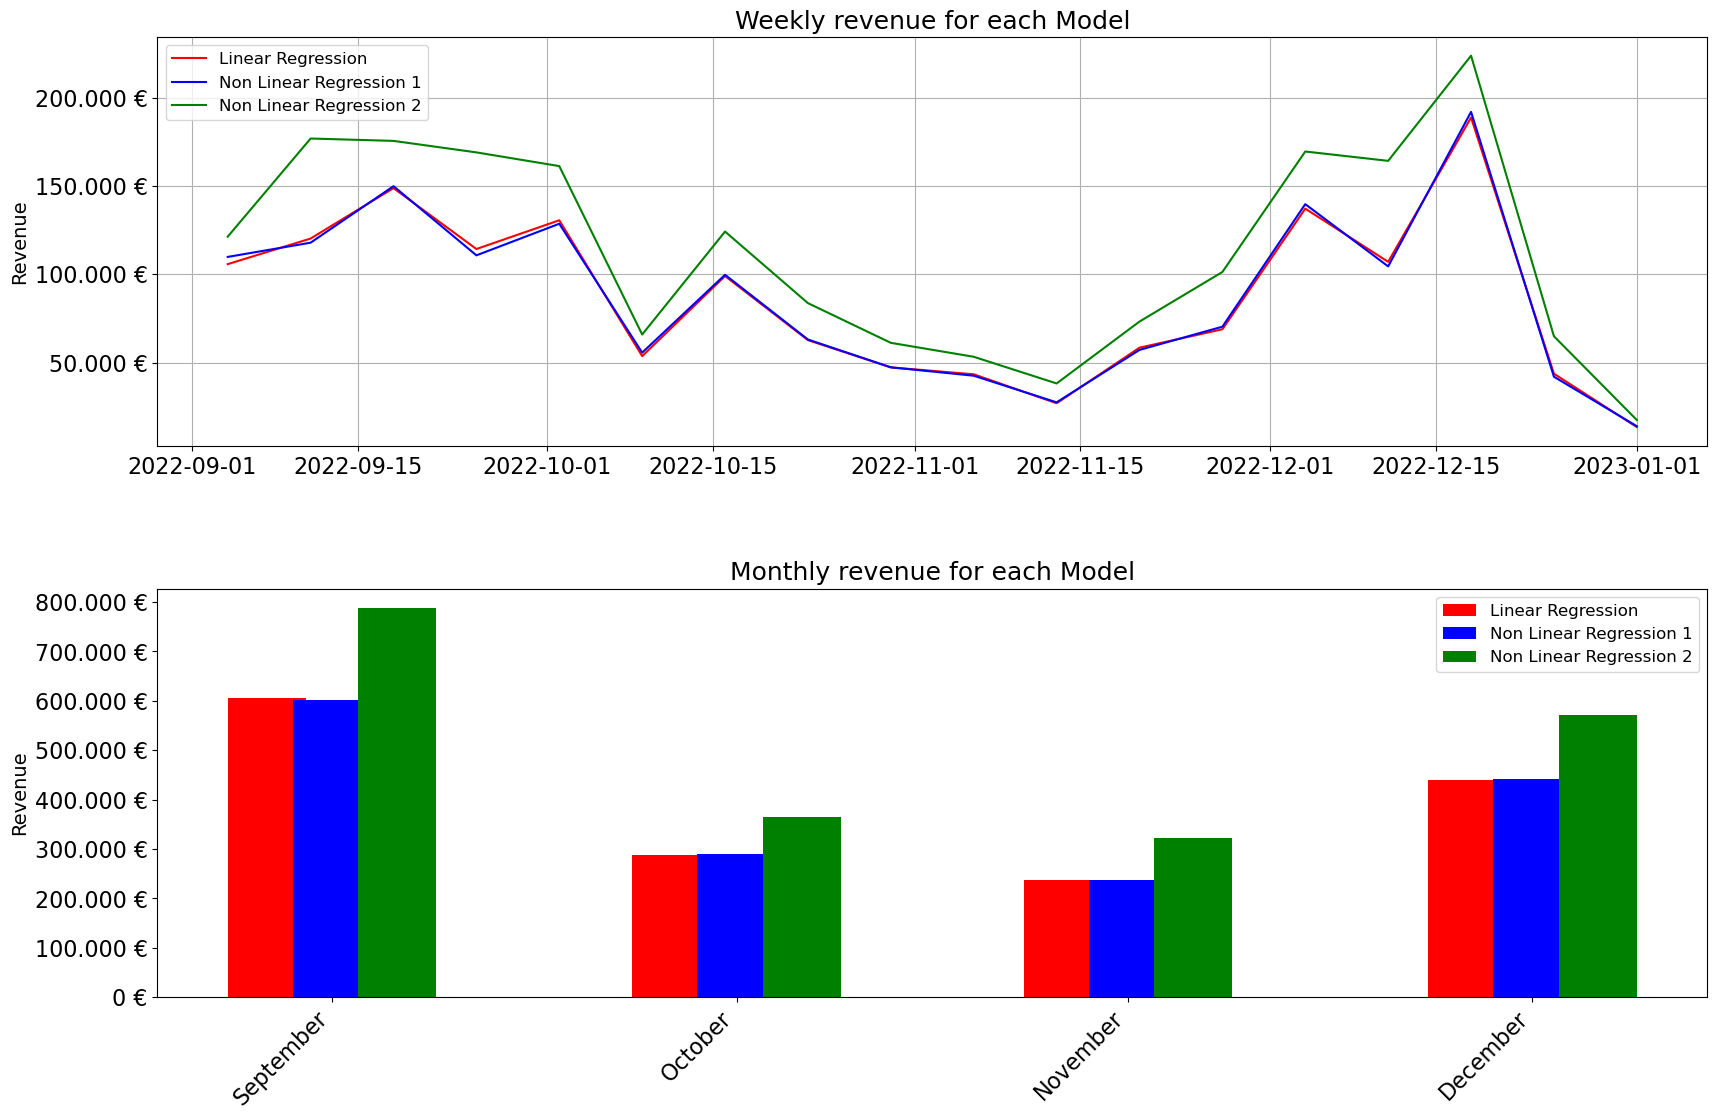

In [27]:
# Creating a consistent datdframe for all revenues of each model 
df_Rev = pd.DataFrame({
    "HourDK": LinRegRev.index,
    'LinRegRev': LinRegRev['Revenue'],
    'NonLinReg1Rev': NonLinReg1Rev['Revenue'],
    'NonLinReg2Rev': NonLinReg2Rev['Revenue']
})

df_Rev = df_Rev.reset_index(drop=True)


# save the revenues to a csv
df_Rev.to_csv("./Data assignment 1/Revenue_model1_final.csv", index=False)

# visualize the revenues on a weekly and monthly basis
df_Rev['HourDK'] = pd.to_datetime(df_Rev['HourDK'])
df_Rev.set_index('HourDK', inplace=True)
VisRevenue(df_Rev)

### Step 7 Suggestion for improvement 
#### Step 7.1 K-means clustering

C:\Users\ilsed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ilsed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


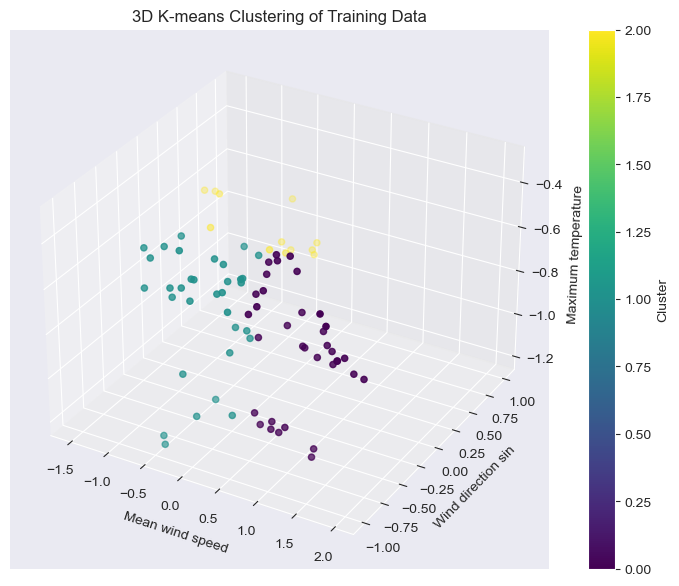

In [97]:
# K-Means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')

# Fit KMeans on the training data (without the bias term)
kmeans.fit(X_sample_train_with_bias[:, 1:])

# Get cluster labels for training data
X_sample_train['Cluster'] = kmeans.labels_

# Get cluster labels for test data
X_sample_test['Cluster'] = kmeans.predict(X_sample_test_with_bias[:, 1:])

# 3D Scatter plot for three features
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for three features: wind speed, wind direction sin, and temperature
sc = ax.scatter(
    X_sample_train['Mean wind speed'], 
    X_sample_train['Wind direction sin'], 
    X_sample_train['Maximum temperature'], 
    c=X_sample_train['Cluster'], cmap='viridis', marker='o')

ax.set_title('3D K-means Clustering of Training Data')
ax.set_xlabel('Mean wind speed')
ax.set_ylabel('Wind direction sin')
ax.set_zlabel('Maximum temperature')
plt.colorbar(sc, label='Cluster')
plt.show()


#### Step 7.2 Apply different regression models on each cluster
Closed-form linear regression

In [98]:
# Iterate through each cluster
unique_clusters = X_sample_train['Cluster'].unique()
results = {}

for cluster in unique_clusters:
    # Select data points for the current cluster
    X_cluster_train = X_sample_train[X_sample_train['Cluster'] == cluster].drop(columns=['Cluster'])
    y_cluster_train = y_sample_train[X_sample_train['Cluster'] == cluster]

    X_cluster_test = X_sample_test[X_sample_test['Cluster'] == cluster].drop(columns=['Cluster'])
    y_cluster_test = y_sample_test[X_sample_test['Cluster'] == cluster]

    # Add bias column to the cluster-specific data (for both train and test)
    X_cluster_train_with_bias = np.c_[np.ones(X_cluster_train.shape[0]), X_cluster_train]
    X_cluster_test_with_bias = np.c_[np.ones(X_cluster_test.shape[0]), X_cluster_test]

    # Apply Gradient Descent
    theta_gd_cluster = gradient_descent(X_cluster_train_with_bias, y_cluster_train)

    # Predictions using Gradient Descent for test data
    y_pred_gd_cluster = X_cluster_test_with_bias @ theta_gd_cluster

    # Apply Closed-form solution (Normal Equation)
    theta_closed_form_cluster = np.linalg.inv(X_cluster_train_with_bias.T @ X_cluster_train_with_bias) @ X_cluster_train_with_bias.T @ y_cluster_train

    # Predictions using Closed-form solution for test data
    y_pred_closed_form_cluster = X_cluster_test_with_bias @ theta_closed_form_cluster

    # Store results for this cluster
    results[cluster] = {
        "theta_gd": theta_gd_cluster,
        "y_pred_gd": y_pred_gd_cluster,
        "theta_closed_form": theta_closed_form_cluster,
        "y_pred_closed_form": y_pred_closed_form_cluster,
    }


In [99]:
def evaluate_model(y_true, y_pred):
    if len(y_true) == 0 or len(y_pred) == 0:
        print("No test samples for this cluster.")
        return
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared
    r2 = r2_score(y_true, y_pred)
    
    # Print the results
    print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
    print(f"Mean Squared Error (MSE): {mse:.5f}")
    print(f"Mean Absolute Error (MAE): {mae:.5f}")
    print(f"R-squared: {r2:.5f}")

# Iterate through each cluster and evaluate the model
unique_clusters = X_sample_train['Cluster'].unique()

for cluster in unique_clusters:
    # Select data points for the current cluster
    X_cluster_test = X_sample_test[X_sample_test['Cluster'] == cluster].drop(columns=['Cluster'])
    y_cluster_test = y_sample_test[X_sample_test['Cluster'] == cluster]

    if len(X_cluster_test) == 0:
        print(f"No test data available for Cluster {cluster}.")
        continue
    
    # Gradient Descent Predictions (assumes y_pred_gd_cluster is already calculated for this cluster)
    print(f"Evaluating Cluster {cluster} with Gradient Descent predictions:")
    y_pred_gd_cluster = results[cluster]['y_pred_gd']
    evaluate_model(y_cluster_test, y_pred_gd_cluster)

    # Closed-Form Predictions
    print(f"Evaluating Cluster {cluster} with Closed-Form Solution predictions:")
    y_pred_closed_form_cluster = results[cluster]['y_pred_closed_form']
    evaluate_model(y_cluster_test, y_pred_closed_form_cluster)


Evaluating Cluster 0 with Gradient Descent predictions:
Root Mean Squared Error (RMSE): 0.14742
Mean Squared Error (MSE): 0.02173
Mean Absolute Error (MAE): 0.11180
R-squared: 0.54355
Evaluating Cluster 0 with Closed-Form Solution predictions:
Root Mean Squared Error (RMSE): 0.19409
Mean Squared Error (MSE): 0.03767
Mean Absolute Error (MAE): 0.14433
R-squared: 0.20888
Evaluating Cluster 1 with Gradient Descent predictions:
Root Mean Squared Error (RMSE): 0.36296
Mean Squared Error (MSE): 0.13174
Mean Absolute Error (MAE): 0.32154
R-squared: -3.20694
Evaluating Cluster 1 with Closed-Form Solution predictions:
Root Mean Squared Error (RMSE): 0.36296
Mean Squared Error (MSE): 0.13174
Mean Absolute Error (MAE): 0.32154
R-squared: -3.20695
No test data available for Cluster 2.


Polynomial non-linear regression

In [100]:
# Function to perform polynomial regression using Closed-form Solution (Normal Equation)
def polynomial_regression_closed_form(X_train, y_train, X_test, degree=4):
    # Add polynomial features up to the specified degree
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Add a column of ones for the bias term to the polynomial features
    X_train_poly_with_bias = np.c_[np.ones(X_train_poly.shape[0]), X_train_poly]
    X_test_poly_with_bias = np.c_[np.ones(X_test_poly.shape[0]), X_test_poly]

    # Closed-form solution (Normal Equation) on polynomial features
    theta_closed_form_poly = np.linalg.inv(X_train_poly_with_bias.T @ X_train_poly_with_bias) @ X_train_poly_with_bias.T @ y_train

    # Predictions using closed-form solution
    y_pred_closed_form_poly = X_test_poly_with_bias @ theta_closed_form_poly

    return theta_closed_form_poly, y_pred_closed_form_poly

# Iterate through each cluster and apply polynomial regression (Closed-form)
unique_clusters = X_sample_train['Cluster'].unique()
polynomial_results = {}


In [101]:
for cluster in unique_clusters:
    # Select data points for the current cluster
    X_cluster_train = X_sample_train[X_sample_train['Cluster'] == cluster].drop(columns=['Cluster'])
    y_cluster_train = y_sample_train[X_sample_train['Cluster'] == cluster]

    X_cluster_test = X_sample_test[X_sample_test['Cluster'] == cluster].drop(columns=['Cluster'])
    y_cluster_test = y_sample_test[X_sample_test['Cluster'] == cluster]

    # Check if both training and test data are available for the cluster
    if len(X_cluster_train) == 0:
        print(f"No training data available for Cluster {cluster}. Skipping polynomial regression.")
        continue
    if len(X_cluster_test) == 0:
        print(f"No test data available for Cluster {cluster}. Skipping polynomial regression.")
        continue

    # Apply polynomial regression (Closed-form solution) for the current cluster
    theta_closed_form_poly, y_pred_closed_form_poly = polynomial_regression_closed_form(
        X_cluster_train, y_cluster_train, X_cluster_test, degree=4)

    # Ensure the number of predictions match the actual test data size
    if len(y_cluster_test) == len(y_pred_closed_form_poly):
        # Calculate and print error metrics for the current cluster
        rmse = np.sqrt(mean_squared_error(y_cluster_test, y_pred_closed_form_poly))
        mse = mean_squared_error(y_cluster_test, y_pred_closed_form_poly)
        mae = mean_absolute_error(y_cluster_test, y_pred_closed_form_poly)
        r2 = r2_score(y_cluster_test, y_pred_closed_form_poly)

        print(f"Cluster {cluster} - RMSE: {rmse:.5f}, MSE: {mse:.5f}, MAE: {mae:.5f}, R-squared: {r2:.5f}")
    else:
        print(f"Cluster {cluster} - Mismatch in the number of samples between test and prediction. "
              f"Test samples: {len(y_cluster_test)}, Predictions: {len(y_pred_closed_form_poly)}")


Cluster 0 - RMSE: 13330.24847, MSE: 177695524.23915, MAE: 4965.71216, R-squared: -3731865117.89396
Cluster 1 - RMSE: 1676.82645, MSE: 2811746.95237, MAE: 1076.73401, R-squared: -89790797.06212
No test data available for Cluster 2. Skipping polynomial regression.


Ridge for both linear and non-linear

In [102]:
# Ridge Regression closed-form solution for linear regression
def ridge_regression_closed_form(X_train, y_train, X_test, lambda_, degree=1):
    # Add polynomial features if degree > 1
    if degree > 1:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)
    
    # Add a column of ones for the bias term to X_train and X_test
    X_train_with_bias = np.c_[np.ones(X_train.shape[0]), X_train]
    X_test_with_bias = np.c_[np.ones(X_test.shape[0]), X_test]

    # Identity matrix for regularization (excluding bias term)
    identity_matrix = np.eye(X_train_with_bias.shape[1])
    identity_matrix[0, 0] = 0  # Do not regularize the bias term

    # Closed-form solution for Ridge regression
    XTWX = X_train_with_bias.T @ X_train_with_bias
    regularization_term = lambda_ * identity_matrix
    theta_ridge = np.linalg.inv(XTWX + regularization_term) @ (X_train_with_bias.T @ y_train)

    # Make predictions on the test set
    y_pred_ridge = X_test_with_bias @ theta_ridge

    return theta_ridge, y_pred_ridge

In [103]:
# Iterate through each cluster and apply Ridge Regression for both linear and polynomial regression
unique_clusters = X_sample_train['Cluster'].unique()
ridge_results = {}

lambda_ = 1.0  # Regularization strength (you can tune this)

for cluster in unique_clusters:
    # Select data points for the current cluster
    X_cluster_train = X_sample_train[X_sample_train['Cluster'] == cluster].drop(columns=['Cluster'])
    y_cluster_train = y_sample_train[X_sample_train['Cluster'] == cluster]

    X_cluster_test = X_sample_test[X_sample_test['Cluster'] == cluster].drop(columns=['Cluster'])
    y_cluster_test = y_sample_test[X_sample_test['Cluster'] == cluster]

    # Ensure all features in X_cluster_train and X_cluster_test are numeric
    X_cluster_train = X_cluster_train.apply(pd.to_numeric, errors='coerce').dropna(axis=1)
    X_cluster_test = X_cluster_test.apply(pd.to_numeric, errors='coerce').dropna(axis=1)

    # Convert to float to avoid data type issues
    X_cluster_train = X_cluster_train.astype(float)
    X_cluster_test = X_cluster_test.astype(float)

    if len(X_cluster_test) == 0:
        print(f"No test data available for Cluster {cluster}. Skipping Ridge regression.")
        continue

    # Apply Ridge Regression for linear regression (degree = 1)
    theta_ridge_linear, y_pred_ridge_linear = ridge_regression_closed_form(
        X_cluster_train, y_cluster_train, X_cluster_test, lambda_=lambda_, degree=1)

    # Apply Ridge Regression for polynomial regression (degree = 4)
    theta_ridge_poly, y_pred_ridge_poly = ridge_regression_closed_form(
        X_cluster_train, y_cluster_train, X_cluster_test, lambda_=lambda_, degree=4)

    # Store results for this cluster
    ridge_results[cluster] = {
        "theta_ridge_linear": theta_ridge_linear,
        "y_pred_ridge_linear": y_pred_ridge_linear,
        "theta_ridge_poly": theta_ridge_poly,
        "y_pred_ridge_poly": y_pred_ridge_poly
    }

    # Calculate and print error metrics for linear regression
    if len(y_cluster_test) == len(y_pred_ridge_linear):
        rmse_linear = np.sqrt(mean_squared_error(y_cluster_test, y_pred_ridge_linear))
        mse_linear = mean_squared_error(y_cluster_test, y_pred_ridge_linear)
        mae_linear = mean_absolute_error(y_cluster_test, y_pred_ridge_linear)
        r2_linear = r2_score(y_cluster_test, y_pred_ridge_linear)

        print(f"Cluster {cluster} - Ridge Linear Regression RMSE: {rmse_linear:.5f}, MSE: {mse_linear:.5f}, MAE: {mae_linear:.5f}, R-squared: {r2_linear:.5f}")

    # Calculate and print error metrics for polynomial regression
    if len(y_cluster_test) == len(y_pred_ridge_poly):
        rmse_poly = np.sqrt(mean_squared_error(y_cluster_test, y_pred_ridge_poly))
        mse_poly = mean_squared_error(y_cluster_test, y_pred_ridge_poly)
        mae_poly = mean_absolute_error(y_cluster_test, y_pred_ridge_poly)
        r2_poly = r2_score(y_cluster_test, y_pred_ridge_poly)

        print(f"Cluster {cluster} - Ridge Polynomial Regression RMSE: {rmse_poly:.5f}, MSE: {mse_poly:.5f}, MAE: {mae_poly:.5f}, R-squared: {r2_poly:.5f}")
    else:
        print(f"Cluster {cluster} - Mismatch in the number of samples between test and prediction.")


Cluster 0 - Ridge Linear Regression RMSE: 0.15831, MSE: 0.02506, MAE: 0.13042, R-squared: 0.47364
Cluster 0 - Ridge Polynomial Regression RMSE: 0.41554, MSE: 0.17268, MAE: 0.26934, R-squared: -2.62648
Cluster 1 - Ridge Linear Regression RMSE: 0.30879, MSE: 0.09535, MAE: 0.27096, R-squared: -2.04495
Cluster 1 - Ridge Polynomial Regression RMSE: 0.27581, MSE: 0.07607, MAE: 0.23198, R-squared: -1.42923
No test data available for Cluster 2. Skipping Ridge regression.


About why there is no test data available for Cluster 2: 
1. Cluster 2 (yellow points) appears in small groups located in specific areas of the plot.
2. And when spliting, the dataset is sequentially split without shuffling, and Cluster 2 points are concentrated near the **beginning or end** of the dataset, then all of these points could have ended up in the training set **only**, leaving no data for Cluster 2 in the test set. In the future work, we can avoid such problem by shuffling or stratifying the dataset.